### Example for Deriving Climate Index (here: Nino 3.4) from 2D geospatial data (here: SST anomaly)

In [1]:
import os
import sys
sys.path.append('../reconstruct_missing_data')

from data_loading import find_data_files, load_data_set, get_anomalies

import pandas as pd
import numpy as np
import seaborn as sns
from matplotlib import pyplot as plt
import matplotlib.patches as patches

In [2]:
## Set working directory:

# os.chdir('/gxfs_work1/geomar/smomw511') # nesh
os.chdir('/Users/mlandt-hayen') # local
# os.chdir('/work') # local in Docker Container

### Load data

- Load raw 2D geospatial fields (test data).
- Load collection of climate indices directly from GitHub release.

In [42]:
## Load raw 2D geospatial fields (from test data):

# Set path CESM and FOCI test data:
path_to_ESM_test_data = 'GitHub/MarcoLandtHayen/reconstruct_missing_data/data/test_data/'

# Load CESM and FOCI test data:
data_CESM = load_data_set(data_path=path_to_ESM_test_data, data_source_name='CESM')
data_FOCI = load_data_set(data_path=path_to_ESM_test_data, data_source_name='FOCI')

# Get slp and sst anomalies for CESM and FOCI test data:
slp_CESM_anomaly = get_anomalies(feature='sea-level-pressure', data_set=data_CESM)
sst_CESM_anomaly = get_anomalies(feature='sea-surface-temperature', data_set=data_CESM)
slp_FOCI_anomaly = get_anomalies(feature='sea-level-pressure', data_set=data_FOCI)
sst_FOCI_anomaly = get_anomalies(feature='sea-surface-temperature', data_set=data_FOCI)

# Store grid dimensions:
lat_sst_CESM = data_CESM.lat.values
lon_sst_CESM = data_CESM.lon.values
lat_sst_FOCI = data_FOCI.lat.values
lon_sst_FOCI = data_FOCI.lon.values

/opt/miniconda3/lib/python3.9/site-packages/xarray/coding/times.py:526: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  dtype = _decode_cf_datetime_dtype(data, units, calendar, self.use_cftime)
/opt/miniconda3/lib/python3.9/site-packages/numpy/core/_asarray.py:83: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  return array(a, dtype, copy=False, order=order)


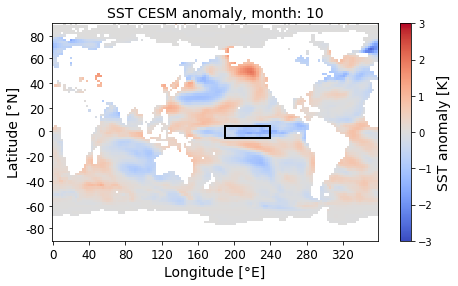

In [103]:
# Plot sst CESM anomaly fields:

i=9

fig, ax = plt.subplots(figsize=(8, 4))
im = plt.imshow(np.flip(sst_CESM_anomaly[i],axis=0), cmap="coolwarm", interpolation='nearest', vmin=-3, vmax=3)
cbar = plt.colorbar(im)
cbar.set_label('SST anomaly [K]', fontsize=14)
plt.title('SST CESM anomaly, month: '+str(i+1), fontsize=14)
plt.xlabel('Longitude [°E]', fontsize=14)
plt.ylabel('Latitude [°N]', fontsize=14)
plt.xticks(np.arange(0, 144, step=16), [0, 40, 80, 120, 160, 200, 240, 280, 320], fontsize=12)
plt.yticks([5, 15, 26, 37, 47, 58, 69, 80, 90], [80, 60, 40, 20, 0, -20, -40, -60, -80], fontsize=12)

# Create a Rectangle patch and add the patch to the Axes
rect = patches.Rectangle((76, 45), 20, 5, linewidth=2, edgecolor='black', facecolor='none')
ax.add_patch(rect)

plt.show()

In [4]:
## Load collection of climate indices directly from GitHub release:

# Set url:
data_url = (
    "https://github.com/MarcoLandtHayen/climate_index_collection/"
    "releases/download/v2023.03.29.1/climate_indices.csv"
)

# Load indices:
climind = pd.read_csv(data_url)

# Set pandas index:
climind = climind.set_index(["model","year","month","index"]).unstack(level=-1)["value"]

In [77]:
# Separate data by model, reset index and drop columns year and month:
climind_FOCI = climind.loc[('FOCI')].reset_index().drop(columns=['year','month'])
climind_CESM = climind.loc[('CESM')].reset_index().drop(columns=['year','month'])

# Extract ENSO_34 index:
target_FOCI = climind_FOCI.loc[:, climind_FOCI.columns == 'ENSO_34']
target_CESM = climind_CESM.loc[:, climind_CESM.columns == 'ENSO_34']

In [78]:
# Define function to specify bar color, according to sign of values:
def bar_color(data,color_pos,color_neg):
    return np.where(data.values>0,color_pos,color_neg).T

Text(0, 0.5, 'Nino 3.4 index')

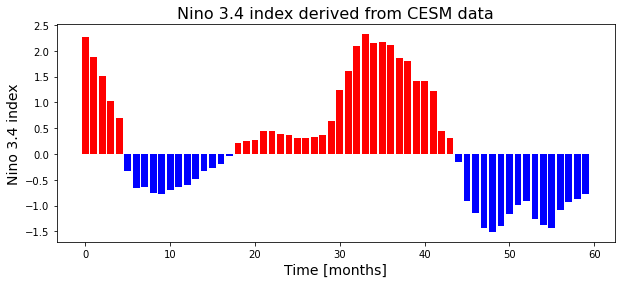

In [110]:
## Plot Nino 3.4 index:

# Define number of months to include:
m = 60

# Get bar color:
nino_bar_color = bar_color(target_CESM[:60],'r','b')[0]

# Only keep the first m bars. Set bar color to "white" for remaining months:
for t in range(60):
    
    if t >= m:
        nino_bar_color[t] = 'w'

# Plot index for first m months:
fig, axes = plt.subplots(1,1,figsize=[10,4])

axes.set_title('Nino 3.4 index derived from CESM data', fontsize=16)

axes.bar(
    x=range(len(target_CESM.values[:60,0])),
    height=target_CESM.values[:60,0],
    color=nino_bar_color,
    label="true targets",
    alpha=1
)

axes.set_xlabel('Time [months]', fontsize=14)
axes.set_ylabel('Nino 3.4 index', fontsize=14)